<a href="https://colab.research.google.com/github/PratyushJha254/BTP/blob/main/XYModel_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

#### Metropolis Algorithm

In [2]:
# https://github.com/rgmelko/Spin-Models-on-GPU/tree/master

In [3]:
from numba import jit

In [4]:
@jit(nopython=True)
def calculate_delta_E(grid, i, j, delta_theta, J):
    L = grid.shape[0]
    neighbors = [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]  # Assuming periodic boundary conditions

    delta_E = 0.0
    for ni, nj in neighbors:
        ni %= L  # Periodic boundary conditions
        nj %= L
        delta_E += -J * (np.cos(grid[ni, nj] - grid[i, j] - delta_theta) - np.cos(grid[ni, nj] - grid[i, j]))

    return delta_E

In [5]:
import numpy as np
from numba import jit

@jit(nopython=True)
def data_generation_internal(l, J):
    L = l  # grid size

    temperatures = np.arange(0.1, 3.51, 0.1)  # 26
    ntherm = 40000  # thermalization steps
    nsamples = 100  # number of samples for every starting configuration
    nbin = 10  # number of starting configurations

    n = len(temperatures) * nbin * nsamples  # total number of samples

    C = np.empty((n, L, L))
    T = np.empty(n)

    c = 0
    for t in temperatures:
        for i in range(nbin):
            # start with random spins
            grid = np.random.uniform(-np.pi, np.pi, size=(L, L))
            # draw a number of sample configurations
            for j in range(nsamples):
                # perform a number of updates until thermalization
                for k in range(ntherm):
                    # choose a random site
                    ix, iy = np.random.randint(0, L), np.random.randint(0, L)
                    # calculate energy difference
                    d_theta = np.random.uniform(-np.pi, np.pi)
                    dE = calculate_delta_E(grid, ix, iy, d_theta, J)
                    # decide whether to accept or reject the move
                    if dE < 0 or np.random.rand() < np.exp(-dE / t):
                        grid[ix, iy] += d_theta

                C[c] = grid
                T[c] = t
                c += 1

    return C, T


In [6]:
def data_generation(l, name, J):
    C, T = data_generation_internal(l, J)
    # p = np.random.permutation(len(C))
    np.savez_compressed(name, X=C, y=T)

In [7]:
data_generation(32, 'data_xy32.npz', 1)

#### Loading and visualizing the data

In [8]:
data = np.load('data_xy32.npz')

In [9]:
img = data['X']
temperatures = data['y']

In [ ]:
for i in range(len(temperatures)):
  if(temperatures[i]>0.2 and temperatures[i]<0.4):
    print(i)
    break

2000


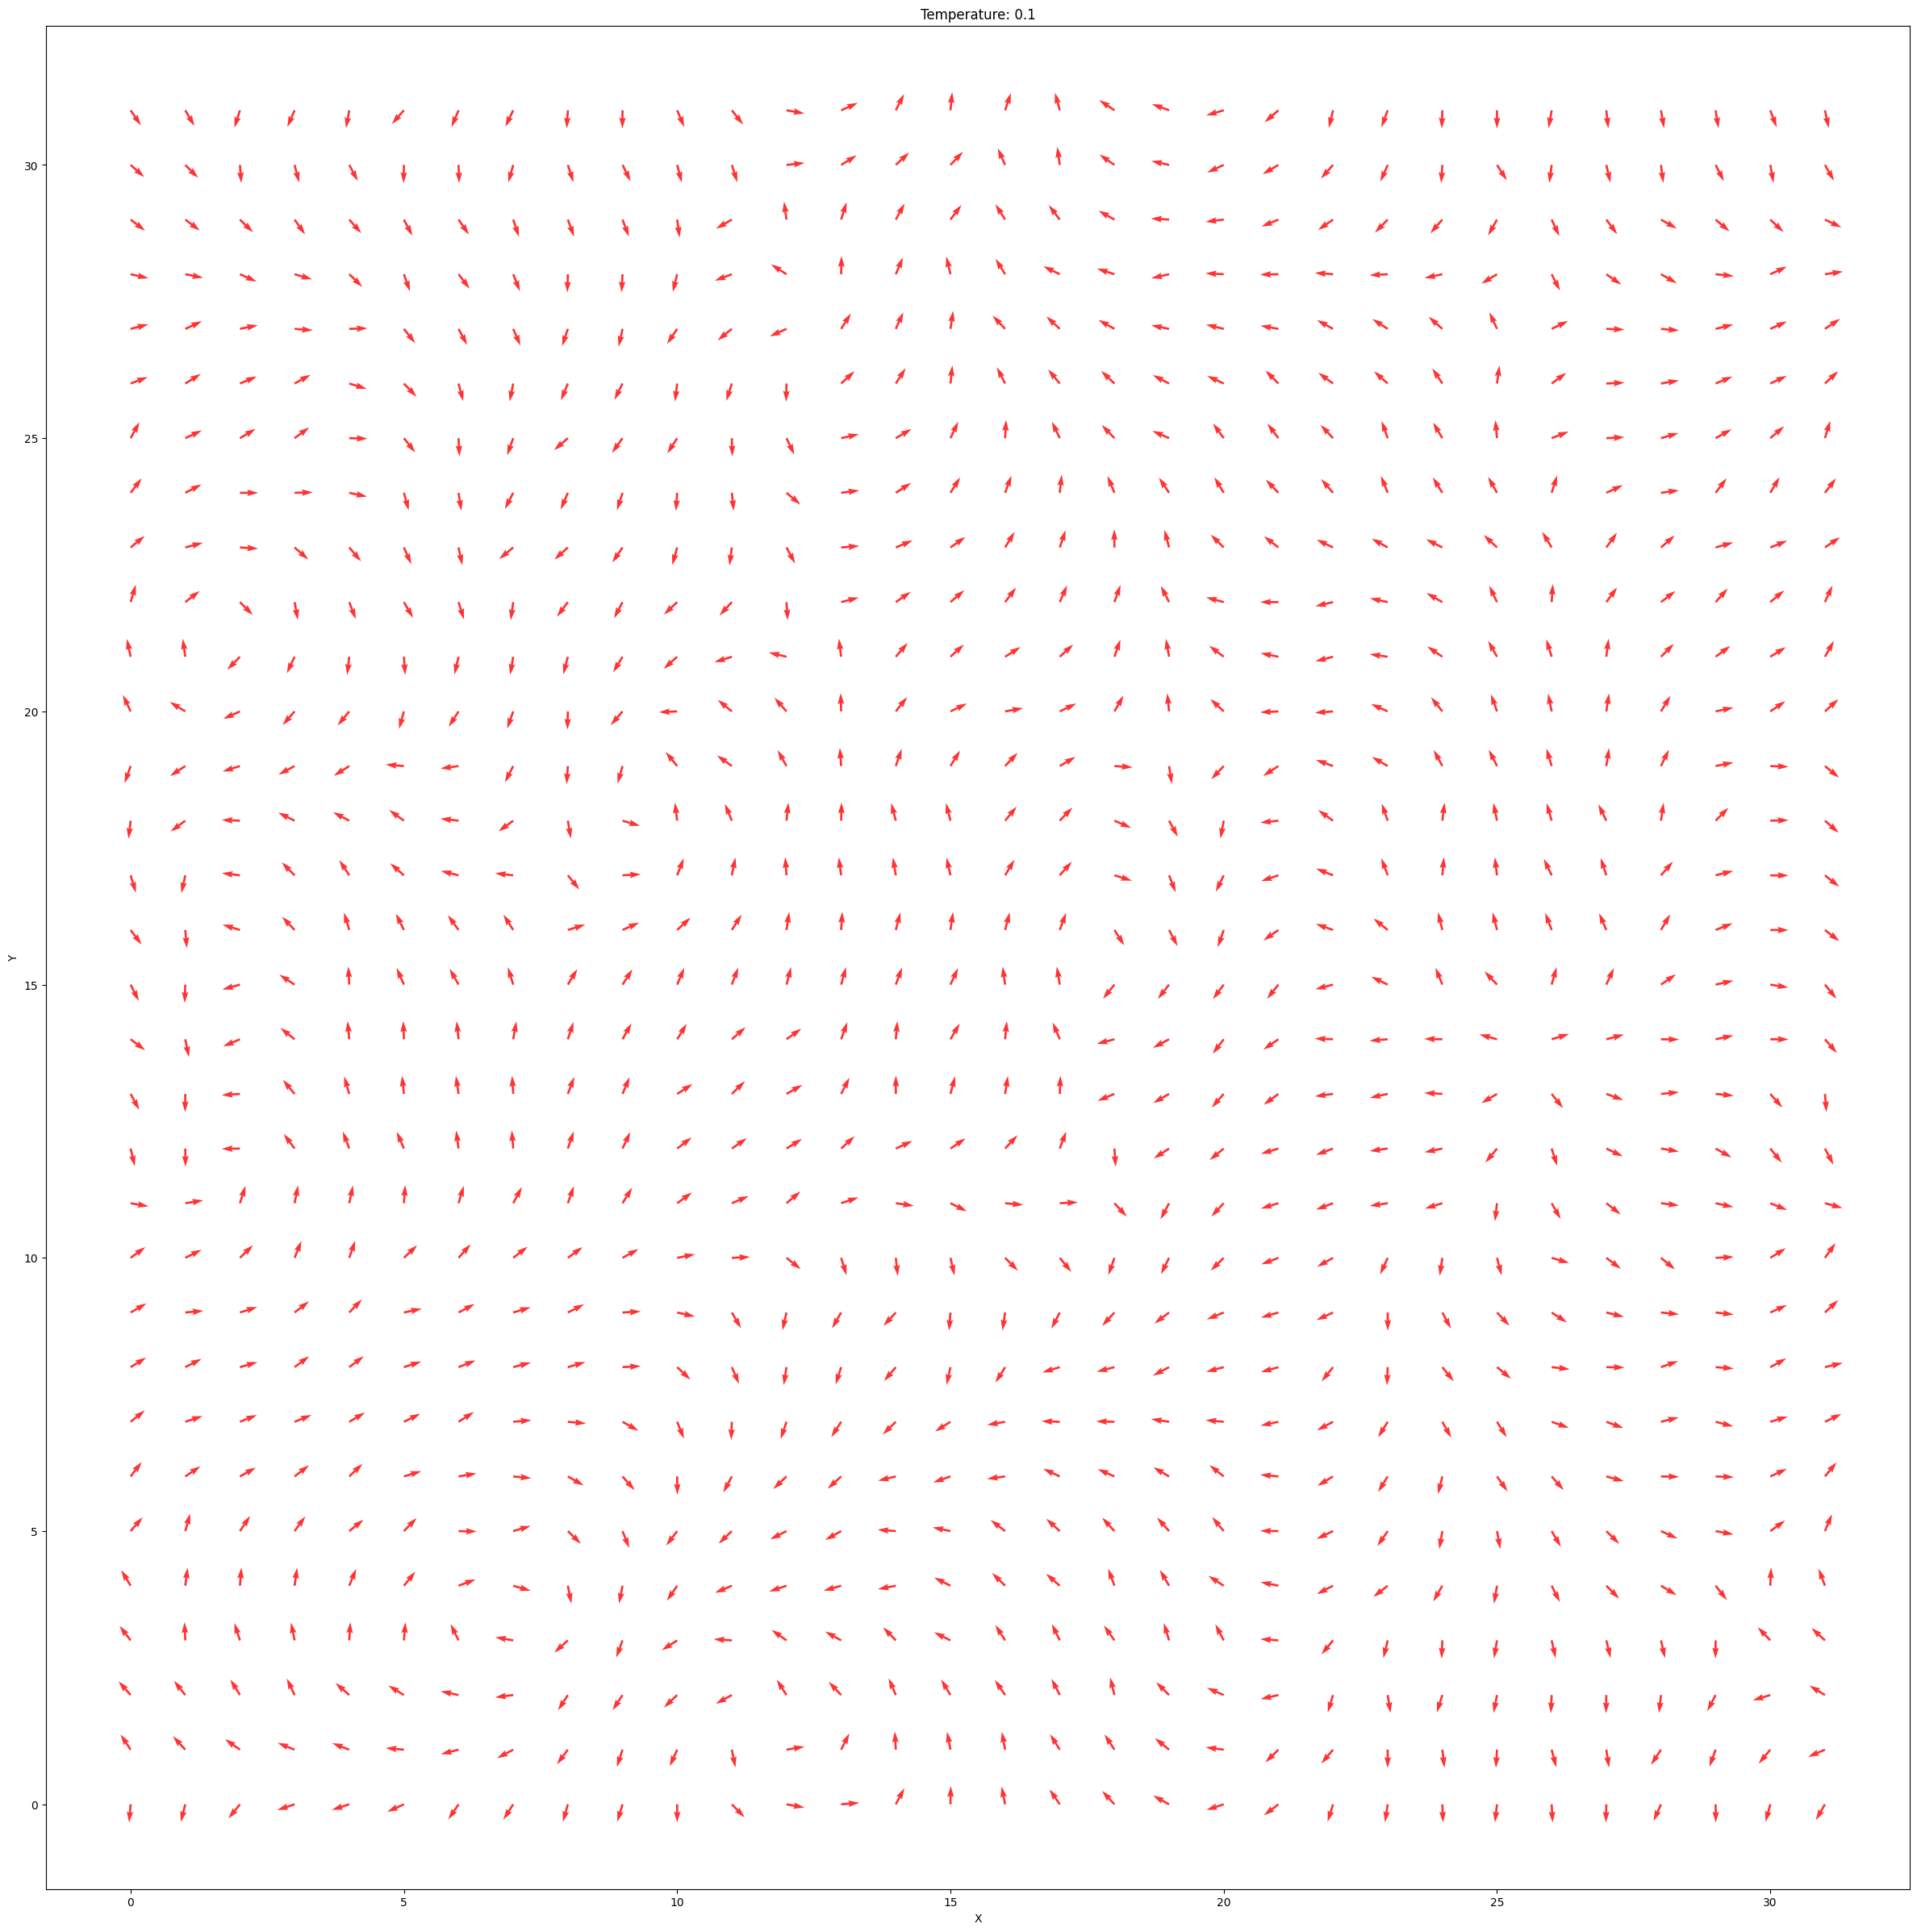

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_data(data, temperature):
    # Define grid
    x = np.arange(0, 32, 1)
    y = np.arange(0, 32, 1)
    X, Y = np.meshgrid(x, y)

    # Calculate spin directions
    U = np.cos(data)
    V = np.sin(data)

    # Create plot
    fig, ax = plt.subplots(figsize=(30, 30))
    ax.quiver(X, Y, U, V, scale=3, units='xy', width=0.04, color='red', alpha=0.8)  # Adjust scale for larger arrows
    ax.set_aspect('equal', 'box')
    ax.set_title(f"Temperature: {temperature}")
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    plt.show()

# Example usage
visualize_data(img[100], temperatures[100])


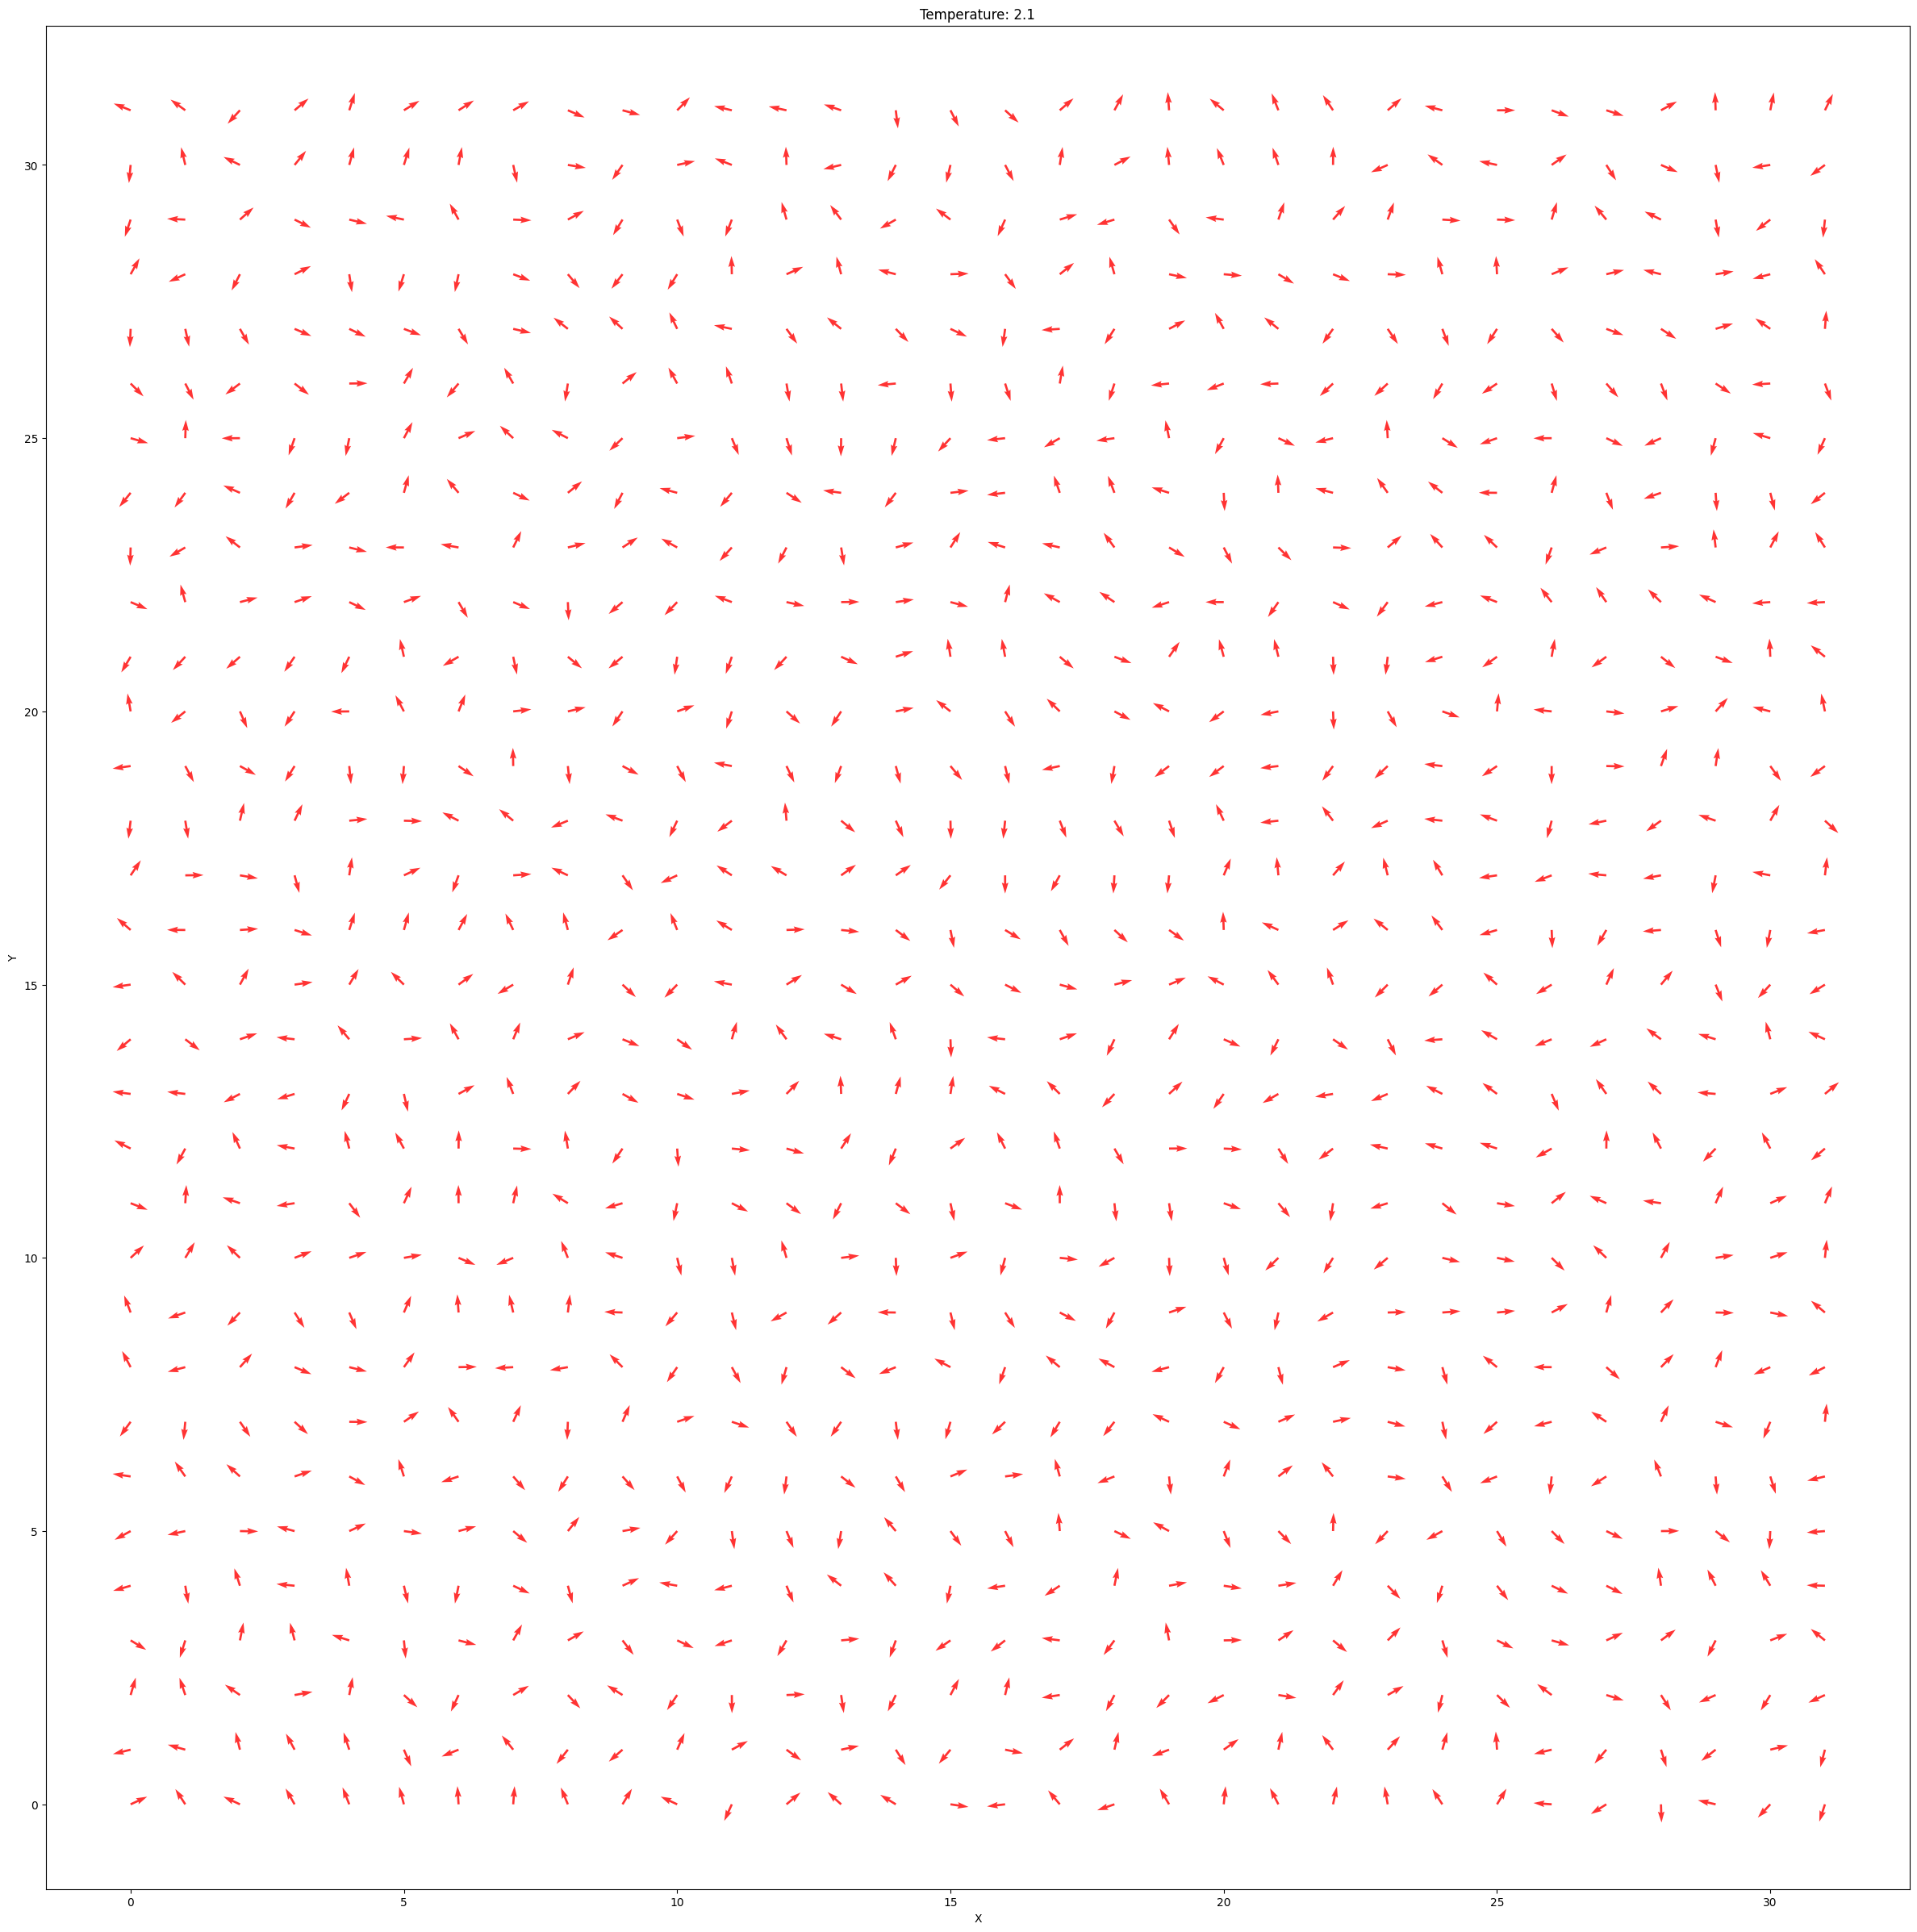

In [18]:
# Example usage
visualize_data(img[20000], temperatures[20000])

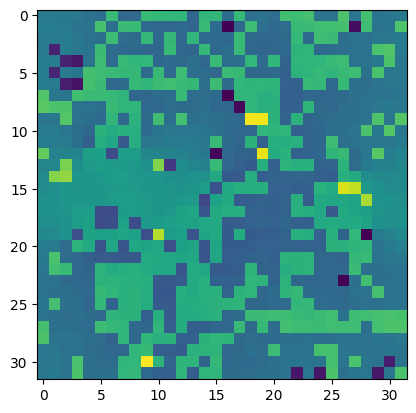

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(img[10])

#### Trying to get the correlation length

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from numba import jit

# @jit(nopython=True)
# def calculate_correlation_length(lattice):
#     def _func(x, R, f_log):
#         return R + x[0] * f_log - x[0] * x[1]

#     def least_squares(func, x0, kwargs):
#         return 0.0  # Placeholder for least squares calculation

#     correlations = np.zeros(lattice.shape[0] // 2)
#     for r in range(correlations.shape[0]):
#         rolled = np.roll(lattice, r, axis=0)
#         rolled = np.roll(rolled, r, axis=1)
#         correlations[r] = np.mean(np.cos(2 * np.pi * (lattice - rolled)))
#     bounds = len(correlations) // 5
#     ls = least_squares(_func, [0, 0], kwargs={'R': np.arange(bounds, len(correlations) - bounds),
#                                               'f_log': np.log(np.maximum(correlations[bounds:-bounds], [1e-10] * (len(correlations) - 2 * bounds)))})
#     return 1 / ls

# data = np.load('data_xy32.npz')
# img = data['X']
# temperatures = data['y']

# correlation_lengths = []
# current_temp = temperatures[0]
# correlation_sum = 0
# count = 0

# for lattice, temp in zip(img, temperatures):
#     if temp != current_temp:
#         correlation_lengths.append(correlation_sum / count)
#         correlation_sum = 0
#         count = 0
#         current_temp = temp
#     correlation_sum += calculate_correlation_length(lattice)
#     count += 1

# # Add the correlation length for the last temperature
# correlation_lengths.append(correlation_sum / count)

# # Plotting the scatter plot
# plt.scatter(np.arange(0.1, 3.51, 0.1), correlation_lengths, color='blue', marker='.')
# plt.xlabel('Temperature')
# plt.ylabel('Correlation Length')
# plt.title('Correlation Length vs Temperature')
# plt.grid(True)
# plt.show()


In [ ]:
# import numpy as np
# from scipy.optimize import least_squares

# def calculate_correlation_length(lattice):
#     def optimized_func(x, R, f_log):
#         return R + x[0] * f_log - x[0] * x[1]

#     correlations = []
#     for r in range(int(lattice.shape[0] / 2)):
#         rolled = np.roll(lattice, r, axis=0)
#         rolled = np.roll(rolled, r, axis=1)
#         correlations.append(np.mean(np.cos(2 * np.pi * (lattice - rolled))))
#     correlations = np.array(correlations)
#     bounds = int(len(correlations) / 5)
#     ls = least_squares(optimized_func, [0, 0], kwargs={'R' : np.arange(bounds, len(correlations) - bounds),
#                                                        'f_log' : np.log(np.maximum(correlations[bounds:-bounds], [1e-10] * (len(correlations) - 2 * bounds)))})
#     return 1 / ls.x[0]

# # Example usage:
# lattice = img[999]  # Example lattice matrix
# correlation_length = calculate_correlation_length(lattice)
# print("Correlation Length:", correlation_length)


Correlation Length: 4.238286917763834


In [ ]:
# # Initialize lists to store correlation lengths and temperatures
# correlation_lengths = np.zeros(1000)
# base = 30000
# # Iterate over each lattice state
# for i in range(base,base+1000):
#     lattice_state = img[i]
#     correlation_length = calculate_correlation_length(lattice_state)
#     correlation_lengths[i-base] = correlation_length

# # Plotting the correlation length graph
# # plt.scatter(temperatures, correlation_lengths, color='blue', marker='.')
# # plt.xlabel('Temperature')
# # plt.ylabel('Correlation Length')
# # plt.title('Correlation Length vs Temperature')
# # plt.grid(True)
# # plt.show()
# np.sum(correlation_lengths)/1000

In [ ]:
# base = 0, 3074.050229361014
# base = 1000, 3733.657140045942
# base = 2000, 4321.595494700788

# base=20000, corr len = 4276.248452135125
# base=30k, 4228.902782339928

In [ ]:
import numpy as np
from scipy.optimize import curve_fit

def correlation_function(lattice_state):
    L = lattice_state.shape[0]  # Size of the lattice
    correlation = np.zeros(L//2)

    for r in range(1, L//2 + 1):
        sum_corr = 0
        count = 0
        for i in range(L):
            for j in range(L):
                neighbor1 = lattice_state[i, j]
                neighbor2 = lattice_state[(i + r) % L, (j + r) % L]
                sum_corr += neighbor1 * neighbor2
                count += 1
        correlation[r-1] = sum_corr / count

    return correlation

def exponential_decay(x, A, xi):
    return A * np.exp(-x / xi)

def calculate_correlation_length(correlation):
    r = np.arange(1, len(correlation) + 1)
    initial_guess = (1.0, 1.0)  # Initial guess for parameters A and xi
    popt, _ = curve_fit(exponential_decay, r, correlation, p0=initial_guess, maxfev=10000)
    return popt[1]

# Example usage
L = 32  # Size of the lattice
lattice_state = img[15999]  # Example lattice state

correlation = correlation_function(lattice_state)
correlation_length = calculate_correlation_length(correlation)

print("Correlation Length:", correlation_length)


Correlation Length: 0.6046212158439649


In [ ]:
# Initialize lists to store correlation lengths and temperatures
correlation_lengths = np.zeros(1000)
corr = np.zeros(35)
k=0
# Iterate over each lattice state
for i in range(len(img)):
    lattice_state = img[i]
    correlation = correlation_function(lattice_state)
    correlation_length = calculate_correlation_length(correlation)
    correlation_lengths[i-k*1000] = correlation_length
    if(i%1000 == 999):
      corr[k]=np.sum(correlation_lengths)/1000
      correlation_lengths = np.zeros(1000)
      k+=1

# Plotting the correlation length graph
plt.scatter(np.arange(0.1,3.51,0.1), corr, color='blue', marker='.')
plt.xlabel('Temperature')
plt.ylabel('Correlation Length')
plt.title('Correlation Length vs Temperature')
plt.grid(True)
plt.show()
np.sum(correlation_lengths)/1000

In [ ]:
class XYDataset(Dataset):
    def __init__(self, file_path):
        self.data = np.load(file_path)
        self.labels = self.data[:, -1]  # Assuming labels are the last column
        self.images = self.data[:, :-1]  # Assuming images are the remaining columns

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # image = self.images[idx].reshape(1, 20, 20)  # Reshape image to [1, 20, 20]
        image = self.images[idx]
        image = torch.tensor(image, dtype=torch.float32)  # Convert to PyTorch tensor
        label = torch.tensor(int(self.labels[idx]), dtype=torch.int64)  # Convert to PyTorch tensor
        return {'image': image, 'label': label}


#### CNN

In [19]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import pickle
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcol
import matplotlib.cm as cm
from keras.utils import to_categorical
import keras.layers as layers
from keras import Sequential
from numba import jit

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import sys
from torch.autograd import Variable
from torch.autograd import grad as torch_grad
import seaborn as sns

In [25]:
def file_loader(file_name):
    data = np.load(file_name)
    X = data['X']
    y = data['y']
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.15)
    Tc = 0.89 # For a square lattice following Ising Model
    y_train = Y_train > Tc
    y_test = Y_test > Tc
    y_train = to_categorical(y_train.astype(int))
    y_test = to_categorical(y_test.astype(int))
    return X_train, X_test, y_train, y_test, Y_train, Y_test

In [26]:
X_train, X_test, y_train, y_test, Y_train, Y_test = file_loader('data_xy32.npz')

In [27]:
class XYDataset(Dataset):
    def __init__(self, x, y):
        self.n_samples = x.shape[0]
        self.x = torch.tensor(torch.from_numpy(x))
        self.y = torch.tensor(torch.from_numpy(y))

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.n_samples

In [28]:
training_dataset = XYDataset(X_train, y_train)
testing_dataset = XYDataset(X_test, y_test)
batch_size = 128
train_dataloader = DataLoader(dataset = training_dataset, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(dataset = testing_dataset, batch_size = batch_size, shuffle = True)

<ipython-input-27-e63f26ea9db7>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(torch.from_numpy(x))
<ipython-input-27-e63f26ea9db7>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(torch.from_numpy(y))


In [29]:
nu_G = 10
Ny = 32
Nx = 32
nc = 1
nz = 100
ngf = 64
ndf = 64
num_epochs = 50
lr = 0.0001
beta1 = 0.5
ngpu = 1
N = Ny * Nx
device = torch.device('cuda:0' if (torch.cuda.is_available() and ngpu > 0) else 'cpu')

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BinaryClassificationCNN(nn.Module):
    def __init__(self, Nx, Ny):
        super(BinaryClassificationCNN, self).__init__()
        self.Nx = Nx  # Width of the input matrix
        self.Ny = Ny  # Height of the input matrix

        # Convolutional Layer 1: input channels = 1, output channels = 8, kernel size = 3x3
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        # Convolutional Layer 2: input channels = 8, output channels = 16, kernel size = 3x3
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        # Max pooling layer reduces size by a factor of 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate the size of the output from the last conv layer after max pooling
        # This is necessary to know how many input features the first fully connected layer expects
        self.final_dim_x = Nx // 2  # Division by 2 due to max pooling
        self.final_dim_y = Ny // 2

        # Fully Connected Layer
        self.fc1 = nn.Linear(16 * self.final_dim_x * self.final_dim_y, 32)
        # Output layer with a single unit for binary classification
        self.output = nn.Linear(32, 2)

    def forward(self, x):
        x = x.view(-1, 1, self.Nx, self.Ny)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        # Flatten the output for the fully connected layer
        x = x.view(-1, 16 * self.final_dim_x * self.final_dim_y)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.output(x))
        return x



In [37]:
# Create an instance of the model and pass the input batch through it
model = BinaryClassificationCNN(Nx, Ny).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))

#### Accuracy, train and test functions

In [41]:
def calculate_accuracy(outputs, labels):
    # Threshold the outputs at 0.5 to get binary predictions: below 0.5 becomes 0, above becomes 1
    predicted = (outputs > 0.5).float()

    # The labels need to have the same dimensions as the predictions for comparison
    # Assuming labels are already in the correct shape (batch_size, 1) or (batch_size,)
    # If not, you might need to adjust labels' shape, e.g., labels = labels.view(-1, 1)

    # Calculate the number of correct predictions
    correct = (predicted == labels).float().sum().item()/2

    # Calculate the total number of labels (which is also the batch size)
    total = labels.size(0)

    # Calculate accuracy as the percentage of correct predictions
    accuracy = correct / total
    return accuracy


In [39]:
def train(model, num_epochs, criterion, optimizer, train_dataloader):
  for epoch in range(num_epochs):
    for i, (x, label) in enumerate(train_dataloader):
      x = x.to(device).float()
      label = label.to(device).float()
      b_size = x.size(0)
      model.zero_grad()
      output = model(x)
      error = criterion(output, label)
      error.backward()
      optimizer.step()
      acc_train = calculate_accuracy(output, label)
      if i % 20 == 0:
        print(f'[{epoch}/{num_epochs}]', 'Loss:', error.item(),',Train accuracy:', acc_train)

In [40]:
def test(model, criterion, test_dataloader):
    for i, (x, label) in enumerate(test_dataloader):
      x = x.to(device).float()
      label = label.to(device).float()
      output = model(x)
      error = criterion(output, label)
      acc_train = calculate_accuracy(output, label)
      if i % 20 == 0:
        print('Loss:', error.item(),',Test accuracy:', acc_train)

In [42]:
train(model, 10, criterion, optimizer, train_dataloader)

Loss: 0.40370047092437744 ,Train accuracy: 0.70703125
Loss: 0.3236682713031769 ,Train accuracy: 0.703125
Loss: 0.25843381881713867 ,Train accuracy: 0.7734375
Loss: 0.2106841504573822 ,Train accuracy: 0.8046875
Loss: 0.2279522716999054 ,Train accuracy: 0.8046875
Loss: 0.20381206274032593 ,Train accuracy: 0.81640625
Loss: 0.22551429271697998 ,Train accuracy: 0.83984375
Loss: 0.20218104124069214 ,Train accuracy: 0.86328125
Loss: 0.20471882820129395 ,Train accuracy: 0.8515625
Loss: 0.1633428931236267 ,Train accuracy: 0.90234375
Loss: 0.18379057943820953 ,Train accuracy: 0.87890625
Loss: 0.17616495490074158 ,Train accuracy: 0.8828125
Loss: 0.1903873085975647 ,Train accuracy: 0.87109375
Loss: 0.17935647070407867 ,Train accuracy: 0.87109375
Loss: 0.16887183487415314 ,Train accuracy: 0.875
Loss: 0.1474977284669876 ,Train accuracy: 0.890625
Loss: 0.138832226395607 ,Train accuracy: 0.8828125
Loss: 0.14799916744232178 ,Train accuracy: 0.87890625
Loss: 0.12308922410011292 ,Train accuracy: 0.894531

In [43]:
test(model, criterion, test_dataloader)

Loss: 0.0008282702183350921 ,Test accuracy: 1.0
Loss: 0.0007333200192078948 ,Test accuracy: 1.0
Loss: 0.001088118413463235 ,Test accuracy: 1.0


#### Attention

In [ ]:
class SpatialAttentionModule(nn.Module):
    def __init__(self, in_channels):
        super(SpatialAttentionModule, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 1, kernel_size=3, padding=1)  # Adjusted kernel size for 20x20 lattice
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        avg_out = torch.mean(x, dim=1, keepdim=True)
        out = torch.cat([max_out, avg_out], dim=1)
        out = self.conv1(out)
        return self.sigmoid(out)


In [ ]:
class BKT_CNN(nn.Module):
    def __init__(self):
        super(BKT_CNN, self).__init__()
        # Feature extraction layers
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Attention module
        self.attention = SpatialAttentionModule(in_channels=64)  # Adjusted input channels
        # Classification layers
        self.fc1 = nn.Linear(64 * 5 * 5, 128)  # Adjusted input size for 20x20 lattice
        self.fc2 = nn.Linear(128, 2)  # 2 output classes for the two phases


    def forward(self, x):
        # Feature extraction
        x = self.features(x)
        # Attention mechanism
        attention = self.attention(x)
        x = x * attention
        # Flatten for fully connected layers
        x = x.view(x.size(0), -1)
        # Classification layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)  # Output probability distribution over the phases


In [ ]:
dataset[0]

{'image': tensor([0.0100, 0.0010]), 'label': tensor(49)}

In [ ]:
# Define your dataset and dataloader
dataset = XYDataset('data.npy')
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Instantiate the model
model = BKT_CNN()

# Move model to CUDA device if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
def train_model(model, dataloader, criterion, optimizer, num_epochs=10, print_every=100):
    model.train()
    device = next(model.parameters()).device  # Get the device from the model's parameters
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, batch in enumerate(dataloader):
            inputs, labels = batch['image'].to(device), batch['label'].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if (i + 1) % print_every == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(dataloader)}], Loss: {running_loss / print_every:.4f}')
                running_loss = 0.0


In [ ]:
# Train the model
train_model(model, dataloader, criterion, optimizer, num_epochs=10, print_every=100)

ValueError: cannot reshape array of size 2 into shape (1,20,20)